# Customer Churn Prediction

In [0]:
#Importing neccessary libraries

import pandas as pd
import pyspark
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#Initialising Spark Session

spark = SparkSession.builder\
    .appName("Sparkify Churn")\
    .getOrCreate()

In [0]:
#Loading data into dataframe

df = spark.read.json("dbfs:/FileStore/shared_uploads/jrnikhil6@gmail.com/mini_sparkify_event_data.json")
print('Total Number of Records : ',df.count())

Total Number of Records :  286500


In [0]:
#First five rows of the dataset

df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [0]:
# Printing the schema of the DataFrame to understand its structure and data types

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [0]:
#Printing the shape of the dataset (Rows,Column)

print("Dataset Shape = (", df.count(), ",", len(df.columns), ")")

Dataset Shape = ( 286500 , 18 )


In [0]:
#Statistical information of each column

df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.11718197783722,None,None,None,None,1.535358834085557E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104714E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201141085,None,99.23517921058324,None,None,None,None,3.291321616328068E9,726.7762634630834,NaN,31.50507848842202,1.5075439608187113E9,None,109091.94999910519
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


## Pre-Processing

In [0]:
# Getting the count of both null and missing values in the dataset

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [0]:
# Examining and printing the number of missing values in each column

print(f"Total number of rows in the dataset: {df.count()}.\n")

for coln in df.columns:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    
    if missing_count > 0:
        nan_count = df.filter(isnan(df[coln])).count()
        null_count = df.filter(df[coln].isNull()).count()
        empty_str = df.filter(df[coln] == "").count()
        print(f"{coln}: {missing_count} missing values. \
        {nan_count} NaN's; {null_count} Null's; {empty_str} empty strings.")

Total number of rows in the dataset: 286500.

artist: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
firstName: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
gender: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
lastName: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
length: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
location: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
registration: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
song: 58392 missing values.         0 NaN's; 58392 Null's; 0 empty strings.
userAgent: 8346 missing values.         0 NaN's; 8346 Null's; 0 empty strings.
userId: 8346 missing values.         0 NaN's; 0 Null's; 8346 empty strings.


In [0]:
#selecting the 'userId' column, droping duplicate values, order the unique values in ascending order by 'userId', and display the first 10 rows.

df.select(['userId']).dropDuplicates().orderBy(df['userId']).show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



From the above code we can find that the 'userID' column has entries with empty strings also. First we need to handle those empty string

In [0]:
# Creating a view to run SQL queries
# A view is a virtual table representing the result of a SQL query or an abstraction over a DataFrame.

df.createOrReplaceTempView("df_table")

In [0]:
#Pages visited by the users whose userID is an empty string

spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|              Login|
|               Help|
|              Error|
|Submit Registration|
|           Register|
+-------------------+



In [0]:
#Pages visited by the users whose userID is not an empty string

spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    EXCEPT
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|             Upgrade|
|      Submit Upgrade|
+--------------------+



From the above results we can come to a conclusion that the user's with empty string are those who are in the middle or prior to sign-in or registration. Since those users are not significant in churn prediction, we drop those rows with empty userID's.

In [0]:
# Dropping rows that have empty userId

df = df.filter(df['userId'] != "")

In [0]:
# Checking the number of missing values in userId and sessionId after processing

print("Number of missing values:")
for coln in ['userId', 'sessionId', 'gender', 'registration', 'userAgent']:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")

Number of missing values:
    userId: 0 missing values.
    sessionId: 0 missing values.
    gender: 0 missing values.
    registration: 0 missing values.
    userAgent: 0 missing values.


Missing values in artist, length and song columns

In [0]:
#Pages visited by the users whose artist values are null.

df.filter(df['artist'].isNull()).select(df['page']).dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [0]:
#Pages visited by the users whose artist values are not null.

df.filter(df['artist'].isNotNull()).select(df['page']).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



Only page event "NextSong", i.e. playing a song, has corresponding artist information. This should apply for each of the artist, length, and song columns

In [0]:
# Checking wheather there is any missing values in the artist, length, song columns when page event is "NextSong"

df_song = df.filter(df['page'] == "NextSong")
print("When page event is 'NextSong':")
for coln in ['artist', 'length', 'song']:
    missing_count = df_song.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")

When page event is 'NextSong':
    artist: 0 missing values.
    length: 0 missing values.
    song: 0 missing values.


In [0]:
#Shape of the dataset after handling missing values

print("Data Shape = (", df.count(), ",", len(df.columns), ")")

Data Shape = ( 278154 , 18 )


In [0]:
# Values in the level column

coln = 'level'
print(f"Possible values of '{coln}' column :")
print([x[coln] for x in df.select(coln).dropDuplicates().collect()])

Possible values of 'level' column :
['free', 'paid']


In [0]:
# Printing the count of free and Paid users

paidUser = df.where(df.level == 'paid').select('userId') .toPandas()['userId']
freeUser = df.where(df.level == 'free').select('userId') .toPandas()['userId']

print('Count of paid users :',paidUser.nunique(),', Count of free users : ', freeUser.nunique())

Count of paid users : 165 , Count of free users :  195


### Defining Churn: event(page) with "Cancellation Confirmation" for both paid and free users. Creating a binary column "Churn" as the target variable for our model, where 1 for customers who churned and 0 for customers who did not.

In [0]:
#Creating our target column "Churn" with respect to page visit of "Cancellation Confirmation" 

flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean = df.withColumn("Churn", flag_churn_event("page"))

#Selecting the max value of churn for each user and making a column name label

df_clean = df_clean.withColumn("label", max('Churn').over(Window.partitionBy('UserId')))     

In [0]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- label: integer (nullable = true)



## EDA

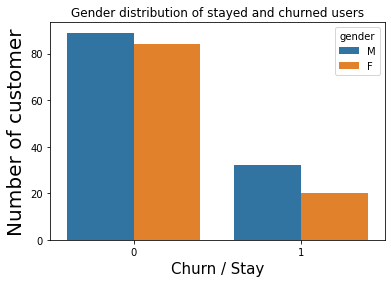

In [0]:
# Plotting a bar plot to show gender distribution between stayed and churned users

gender_pd = df_clean.drop_duplicates(['userId', 'gender']).groupby(['label', 'gender']).count().sort("label").toPandas()

plt.figure()
plt.title('Gender distribution of stayed and churned users')
p = sns.barplot(x = 'label', y = 'count',data = gender_pd, hue = 'gender')
p.set_xlabel("Churn / Stay", fontsize = 15)
p.set_ylabel("Number of customer", fontsize = 20)
plt.show()

## Feature Engineering

In [0]:
# Extract the state name alone from the original address in location column, by splitting with respect to commas into an array and selecting the 2nd entry which is the state name, trimming any available white spaces in it and creating a new column named 'State'.

df_clean = df_clean.withColumn('state', trim(split(col('location'),',').getItem(1)))

# dropping unnecessary column: the original location column, first name and last name.

df_clean = df_clean.drop('location','firstName','lastName')
df_clean.show(n = 5)

+--------------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-----+
|              artist|     auth|gender|itemInSession|   length|level|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|label|state|
+--------------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-----+
|Sleeping With Sirens|Logged In|     F|            0|202.97098| free|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|    0|   CT|
|Francesca Battist...|Logged In|     F|            1|196.54485| free|   PUT| NextSong|1538016340000|       31|Beautiful_ Beauti...|   200|1539003736000|"Mozilla/5.0 (iPh...|100010|    0|    0|   CT|
|    

In [0]:
# Creating month, date columns from timestamp column by converting milli-seconds to seconds and then converting with respect to UTC(Cordinated Universal Time)

df_clean = df_clean.withColumn('epoch_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType())) # convert timestamp to epoch time
df_clean = df_clean.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
df_clean = df_clean.withColumn('month', month(col('epoch_time')))
df_clean.show(5)

+--------------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-----+-------------------+----------+-----+
|              artist|     auth|gender|itemInSession|   length|level|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|label|state|         epoch_time|      date|month|
+--------------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-----+-------------------+----------+-----+
|Sleeping With Sirens|Logged In|     F|            0|202.97098| free|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|    0|   CT|2018-10-08 12:58:54|2018-10-08|   10|
|Francesca Battist...|Logged In|     F|            1|196

In [0]:
# finding out users who downgraded their service

df_clean.filter("page = 'Downgrade'").show(3)

+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+--------------------+------+-----+-----+--------+-------------------+----------+-----+
|artist|     auth|gender|itemInSession|length|level|method|     page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|label|   state|         epoch_time|      date|month|
+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+--------------------+------+-----+-----+--------+-------------------+----------+-----+
|  null|Logged In|     M|           90|  null| paid|   GET|Downgrade|1535389443000|       98|null|   200|1539724886000|"Mozilla/5.0 (Win...|100014|    0|    1|NY-NJ-PA|2018-10-16 21:21:26|2018-10-16|   10|
|  null|Logged In|     M|           24|  null| paid|   GET|Downgrade|1535389443000|      185|null|   200|1542730888000|"Mozilla/5.0 (Win...|100014|    0|    1|NY-NJ-PA|2018-11-

In [0]:
# labeling page visit of downgrade event with 1 for downgraded and 0 for not

flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("Downgrade", flag_downgrade_event("page"))

#Selecting the maximum value of  downgrade for each user and mapping into downgraded column

df_clean = df_clean.withColumn("downgraded", max('Downgrade').over(Window.partitionBy('UserId')))

In [0]:
# Deleting the columns 'Downgrade' and 'Churn' after neccessary processing

df_clean = df_clean.drop('Downgrade','Churn')
df_clean.show(3)

+--------------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-------------------+----------+-----+----------+
|              artist|     auth|gender|itemInSession|   length|level|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|label|state|         epoch_time|      date|month|downgraded|
+--------------------+---------+------+-------------+---------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----+-------------------+----------+-----+----------+
|Sleeping With Sirens|Logged In|     F|            0|202.97098| free|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|   CT|2018-10-08 12:58:54|2018-10-08|   10|         0|
|Francesca Battist...|Logged In|     F| 

In [0]:
# Finding and grouping by the last interaction of each user using the maximum value of timestamp and converting it into a dataframe

cancellation_df = df_clean.groupBy('userId').agg(max('ts').alias('lastinteraction'))

# Combining the converted dataframe with the original dataframe and creating a column named 'registration' with the total number of days a user continued their subscription by substracting the last interacted time stamp with the regitration timestamp and dividing by 86400000 to convert milli-seconds to days.

df_clean = cancellation_df.join(df_clean, on='userId').withColumn('registered_days', ((col('lastinteraction')-col('registration'))/86400000).cast(IntegerType()))

# Dropping 'lastinteraction' and 'registraton' columns after neccessary processing

df_clean = df_clean.drop('lastinteraction','registration')
df_clean.show(2)

+------+--------------------+---------+------+-------------+---------+-----+------+--------+---------+--------------------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+
|userId|              artist|     auth|gender|itemInSession|   length|level|method|    page|sessionId|                song|status|           ts|           userAgent|label|state|         epoch_time|      date|month|downgraded|registered_days|
+------+--------------------+---------+------+-------------+---------+-----+------+--------+---------+--------------------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+
|100010|Sleeping With Sirens|Logged In|     F|            0|202.97098| free|   PUT|NextSong|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|    0|   CT|2018-10-08 12:58:54|2018-10-08|   10|         0|             55|
|100010|Francesca Battist...|Log

In [0]:
# Finding and grouping by the level(free or paid) of each user at the time of last interacton by ordering the timestamp of each user in decending order and converting it into a dataframe

level_df = df_clean.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('level_preChurn'))   

# Dropping the original level column and joining the newly created 'level_preChurn' column to our dataframe

df_clean = df_clean.drop('level')
df_clean = df_clean.join(level_df, on='userId')
df_clean.show(2)

+------+--------------------+---------+------+-------------+---------+------+--------+---------+--------------------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+--------------+
|userId|              artist|     auth|gender|itemInSession|   length|method|    page|sessionId|                song|status|           ts|           userAgent|label|state|         epoch_time|      date|month|downgraded|registered_days|level_preChurn|
+------+--------------------+---------+------+-------------+---------+------+--------+---------+--------------------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+--------------+
|100010|Sleeping With Sirens|Logged In|     F|            0|202.97098|   PUT|NextSong|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|    0|   CT|2018-10-08 12:58:54|2018-10-08|   10|         0|             55|          fr

In [0]:
# Finding the number of songs played by a user in a day and converting it into a dataframe. And then finding the average of songs played by a user.

temp_daily_song = df_clean.groupBy('userId','date').agg(countDistinct('song').alias('songs')).sort('userId')
daily_song = temp_daily_song.groupBy('userId').avg('songs').withColumnRenamed('avg(songs)', 'avg_daily_song')

# Combining the 'average_daily_song' column with the original dataframe and dropping the original 'song' column

df_clean = df_clean.join(daily_song, on='userId')
df_clean = df_clean.drop('song')
df_clean.show(2)

+------+--------------------+---------+------+-------------+---------+------+--------+---------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+--------------+------------------+
|userId|              artist|     auth|gender|itemInSession|   length|method|    page|sessionId|status|           ts|           userAgent|label|state|         epoch_time|      date|month|downgraded|registered_days|level_preChurn|    avg_daily_song|
+------+--------------------+---------+------+-------------+---------+------+--------+---------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+--------------+------------------+
|100010|Sleeping With Sirens|Logged In|     F|            0|202.97098|   PUT|NextSong|       31|   200|1539003534000|"Mozilla/5.0 (iPh...|    0|   CT|2018-10-08 12:58:54|2018-10-08|   10|         0|             55|          free|39.142857142857146|
|100

In [0]:
# Fnding the average time spend by a user in the application with respect to sessionID and creating a column named 'avg_session' to the original dataframe

session_duration = df_clean.groupBy('userId','sessionId').agg(((max('ts')-min('ts'))/86400000).alias('activesession'))
session_duration_df = session_duration.groupBy('userId').avg('activesession').withColumnRenamed('avg(activesession)', 'avg_session')
df_clean = df_clean.join(session_duration_df, on='userId')

#Dropping the original 'sessionID' column from the dataframe

df_clean = df_clean.drop('sessionId')
df_clean.show(2)

+------+--------------------+---------+------+-------------+---------+------+--------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+--------------+------------------+------------------+
|userId|              artist|     auth|gender|itemInSession|   length|method|    page|status|           ts|           userAgent|label|state|         epoch_time|      date|month|downgraded|registered_days|level_preChurn|    avg_daily_song|       avg_session|
+------+--------------------+---------+------+-------------+---------+------+--------+------+-------------+--------------------+-----+-----+-------------------+----------+-----+----------+---------------+--------------+------------------+------------------+
|100010|Sleeping With Sirens|Logged In|     F|            0|202.97098|   PUT|NextSong|   200|1539003534000|"Mozilla/5.0 (iPh...|    0|   CT|2018-10-08 12:58:54|2018-10-08|   10|         0|             55|          free|39.1428

In [0]:
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- epoch_time: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- month: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- registered_days: integer (nullable = true)
 |-- level_preChurn: string (nullable = true)
 |-- avg_daily_song: double (nullable = true)
 |-- avg_session: double (nullable = true)



In [0]:
# Selecting the neccessary columns for building our model

df_model = df_clean.select(['userId','label','downgraded','gender','level_preChurn','state','registered_days','avg_session','avg_daily_song']).dropDuplicates(['userId'])
df_model.show(n=5)

+------+-----+----------+------+--------------+--------+---------------+-------------------+------------------+
|userId|label|downgraded|gender|level_preChurn|   state|registered_days|        avg_session|    avg_daily_song|
+------+-----+----------+------+--------------+--------+---------------+-------------------+------------------+
|100010|    0|         0|     F|          free|      CT|             55| 0.1072800925925926|39.142857142857146|
|100014|    1|         1|     M|          paid|NY-NJ-PA|             85|0.12834297839506173|42.666666666666664|
|100021|    1|         0|     M|          free|      TX|             64|0.14946296296296296|              45.8|
|   101|    1|         1|     M|          paid|      CO|             53|  0.567763888888889|135.76923076923077|
|    11|    0|         1|     F|          paid|   RI-MA|            124|0.11206741898148148|           40.0625|
+------+-----+----------+------+--------------+--------+---------------+-------------------+------------

## Data Transformation

In [0]:
# Creating a list of StringIndexer instances for the specified columns ('gender', 'level_preChurn', 'state'). Each StringIndexer is fitted on the original DataFrame df_model, mapping string values to numerical values and creating a new column with the original column name appended with "_index".

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_model) for column in ['gender','level_preChurn','state'] ]
pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df_model).transform(df_model)

#Dropping those original columns with string entries

df_model = df_r.drop('gender','level_preChurn','state','userId')
df_model.show(1)

+-----+----------+---------------+------------------+------------------+------------+--------------------+-----------+
|label|downgraded|registered_days|       avg_session|    avg_daily_song|gender_index|level_preChurn_index|state_index|
+-----+----------+---------------+------------------+------------------+------------+--------------------+-----------+
|    0|         0|             55|0.1072800925925926|39.142857142857146|         1.0|                 1.0|        5.0|
+-----+----------+---------------+------------------+------------------+------------+--------------------+-----------+
only showing top 1 row



In [0]:
# Selecting the feature columns for our model

feature_columns = [col for col in df_model.columns if col!='label']
feature_columns

Out[37]: ['downgraded',
 'registered_days',
 'avg_session',
 'avg_daily_song',
 'gender_index',
 'level_preChurn_index',
 'state_index']

In [0]:
# Combining the the list of features into a vector and transforming it to the dataset except the target column

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="feature")
df_assembled = assembler.transform(df_model.drop("label"))

# Combining the assembled vector and the target column

combined_df = df_assembled.select("feature").join(
    df_model.select("label"))#, df_assembled.index == df_model.index)

In [0]:
# Using MinMaxScaler to normalize the features within a range of (0,1) and fitting it to our dataframe

scaler = MinMaxScaler(inputCol="feature", outputCol="scaled_features")
scaler_model = scaler.fit(combined_df)
df_new = scaler_model.transform(combined_df)

In [0]:
# Selecting only scaled feature column and target column for further analysis.

trainable_df = df_new.select("scaled_features",'label')

In [0]:
m=df_model.groupBy('label').count().orderBy('count').show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



# Modeling

In [0]:
#splitting of train and test data

train_data,test_data = trainable_df.randomSplit([0.6,0.4])

## Model 1

In [0]:
# Instantiating the RandomForestClassifier model

lr = RandomForestClassifier(featuresCol="scaled_features", labelCol="label",maxBins=64)

# Creating a Pipeline so that the transformation can be applied in a streamlined and organized approach

pipeline1 = Pipeline(stages=[lr])

In [0]:
# Training the model

model1 = pipeline1.fit(train_data)

# Making predictions on the test set

predictions1 = model1.transform(test_data)

In [0]:
# Evaluating the model

evaluator1 = MulticlassClassificationEvaluator(labelCol="label")
f1_score_1 = evaluator1.evaluate(predictions1)

print(f"F1_Score : {f1_score_1}")
print("---------------------------------")
acc_1 = evaluator1.evaluate(predictions1, {evaluator1.metricName: "accuracy"})
print("Accuracy = ",acc_1)

F1_Score : 0.6676590687854768
---------------------------------
Accuracy =  0.7704805041354864


## Model 2

In [0]:
# Instantiating the RandomForestClassifier model

dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label",maxBins=64)

# Creating a Pipeline so that the transformation can be applied in a streamlined and organized approach

pipeline2 = Pipeline(stages=[dt])

# Training the model

model2 = pipeline2.fit(train_data)

# Making predictions on the test set

predictions2 = model2.transform(test_data)

In [0]:
# Evaluating the model

evaluator2 = MulticlassClassificationEvaluator(labelCol="label")
f1_score_2 = evaluator2.evaluate(predictions2)

print(f"F1_Score : {f1_score_2}")
print("---------------------------------")
acc_2 = evaluator2.evaluate(predictions2, {evaluator2.metricName: "accuracy"})
print("Accuracy = ",acc_2)

F1_Score : 0.6676590687854768
---------------------------------
Accuracy =  0.7683215130023641


In [0]:
df_result = pd.Series({'F1 Score of Random Forest Classifier': f1_score_1, 
               'Accuracy of Random Forest Classifier': acc_1,
               'F1 Score of Decision Tree Classifier': f1_score_2,
               'Accuracy of Decision Tree Classifier' :acc_2 })

In [0]:
df_result

Out[49]: F1 Score of Random Forest Classifier    0.667659
Accuracy of Random Forest Classifier    0.770481
F1 Score of Decision Tree Classifier    0.667659
Accuracy of Decision Tree Classifier    0.768322
dtype: float64